
# Lab 2: Sentiment Analysis with a Multi Layer Perceptron using PyTorch

__Objective__: We'll repeat the experiments in Lab 1, but in this case we'll extend the model adding new layers. In addition we will review some of the regularization techniques seen in class. The objectives for the lab session are the following:

- Learn adding layers in PyTorch.
- Experiment using different number of hidden layers with different hidden units.
- Experiment with regularization techniques such as early-stopping, reducing the model, weight regularization and drop-out.


## 1. Loading the data
We'll use the same data used in previous session. You need to follow the same steps specified in lab1.

In [31]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# install libraries
!pip install tensorflow
!pip install datasets==2.17.1
# import load_dataset from dataset
from datasets import load_dataset
# set seed for replicability of results
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
import time
np.random.seed(2)

In [33]:
# device - PyTorch requires explicit device management
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Note: In PyTorch, you need to explicitly move tensors and models to the device using .to(device)
# This is different from Keras/TensorFlow where device management is more automatic

Using device: cuda


In [34]:
# custom data loader path CHANGE home TO YOUR DIRECTORY
home = '/content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/'
sst_home = home + 'utils/sst_custom_loader.py'
# load data with load_dataset and our custom data loader script
data = load_dataset(sst_home)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

Training size: 6920
Dev size: 872
Test size: 1821


/usr/local/lib/python3.12/dist-packages/datasets/load.py:923: FutureWarning: The repository for sst_custom_loader contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## 2. Preprocessing and vectorization

In [35]:
from sklearn.utils import shuffle
import torch
import re
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(2)
np.random.seed(2)

class PyTorchTokenizer:
    def __init__(self, num_words=1000):
        self.num_words = num_words
        self.word_index = {}
        self.word_counts = {}

    def fit_on_texts(self, texts):
        word_counts = Counter()

        for text in texts:
            # simple tokenization - split on whitespace and punctuation
            words = text.split()
            words = [word for word in words if word not in [",", "."]]
            word_counts.update(words)

        # keep only the most frequent words
        most_common = word_counts.most_common(self.num_words - 1)

        # build word index (starting from 1, 0 is reserved)
        self.word_index = {word: idx + 1 for idx, (word, count) in enumerate(most_common)}
        self.word_counts = dict(most_common)

    def texts_to_matrix(self, texts):
        matrix = torch.zeros(len(texts), self.num_words)

        # build the matrix
        for i, text in enumerate(texts):
            words = re.findall(r'\b\w+\b', text.lower())
            for word in words:
                if word in self.word_index:
                    word_idx = self.word_index[word]
                    if word_idx < self.num_words:
                        matrix[i, word_idx] = 1.0

        return matrix


# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors, and tokenize the text
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label

# Create a tokenizer that takes the 1000 most common words
tokenizer = PyTorchTokenizer(num_words=1000)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts)  # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts)
x_dev = tokenizer.texts_to_matrix(dev_texts)
x_test = tokenizer.texts_to_matrix(test_texts)

# Converts the labels to a one-hot representation
y_train = torch.tensor(train_labels.values, dtype=torch.float32).unsqueeze(1)
y_dev = torch.tensor(dev_labels.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(test_labels.values, dtype=torch.float32).unsqueeze(1)

# Create datasets using PyTorch's TensorDataset
train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)
test_dataset = TensorDataset(x_test, y_test)

print('Text of the first examples: \n{}\n'.format(train_texts.iloc[0]))
print('Vector of the first example:\n{}\n'.format(x_train[0]))
print('Binary representation of the output:\n{}\n'.format(y_train[0]))
print('Shape of the training set    (nb_examples, vector_size): {}\n'.format(x_train.shape))
print('Shape of the training labels (nb_examples, vector_size): {}\n'.format(y_train.shape))

Text of the first examples: 
This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .

Vector of the first example:
tensor([0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## 3. Building the model
Based on previous code we'll extend the model to a Multi Layer Perceptron with one hidden layer. For that we'll make use of a fully connected (```Linear```) layers with a ```ReLU``` activation. In this case the hidden layer will have 16 hidden units (feel free to explore different dimensionality of hidden units).

Remember that applying ```Linear``` layer with ```ReLU``` activation we are implementing the following tensor operation:

```
output = relu(W * input + b)
```

**Important PyTorch Note**: Unlike Keras/TensorFlow, PyTorch requires explicit device management. You must use `.to(device)` to move models and data tensors to the appropriate device (CPU or GPU). This is done in the training loop where we call `xb.to(device)` and `yb.to(device)` for each batch, and `model.to(device)` when creating the model.
### Exercise 1
Answer the following questions:
- What does having 16 hidden units mean? What the size of matrix ```W```?

__Answer__: Means that our dense layer output shape is 16, so the W size is a matrix of 1000 X 16 (input_size X output_size)

-----

Increasing the number of hidden units we are allowing the network to learn more complex representations, but at the same time we are making the network more computationally expensive and may lead to overfit the training data.

Regarding the architecture, there are three main decisions that we need to take:
- The number of layers
- The number of hidden units for each layers
- Activation function of the layers

The code below implements a fully connected architecture with only one intermediate layer and an output layer that predicts the sentiment of the input review using PyTorch.

![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/Two_layers_NN.png)

In [36]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    for xb, yb in data_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        # forward pass
        probs, loss = model(xb, yb)
        total_loss += loss.item() * xb.size(0)

        preds = (probs > 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    loss = total_loss / total
    acc = correct / total
    model.train()

    return loss, acc


def train_loop(model, optimizer, epochs):

    # train mode for model
    model.train()

    history = {"loss": [], "dev_loss": [], "acc": [], "dev_acc": []}
    t0 = time.time()
    t_prev = t0

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            probs, loss = model(xb, yb)

            # backward pass
            loss.backward()

            # optimizer step
            optimizer.step()

            # compute metrics
            total_loss += loss.item() * xb.size(0)
            total += yb.size(0)
            with torch.no_grad():
                preds = (probs > 0.5).float()
                correct += (preds == yb).sum().item()

        loss = total_loss / total
        acc = correct / total

        # Evaluation
        dev_loss, dev_acc = evaluate(model, dev_loader)

        # Store info
        history["loss"].append(loss)
        history["dev_loss"].append(dev_loss)
        history["acc"].append(acc)
        history["dev_acc"].append(dev_acc)

        # Logging
        t = time.time()
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train loss: {loss:.4f} - "
            f"Train acc: {acc:.4f} - "
            f"Dev loss: {dev_loss:.4f} - "
            f"Dev acc: {dev_acc:.4f} - "
            f"Time: {(t - t_prev)*1000:.2f}ms"
        )

        # Updates
        t_prev = t

    print(f"Total training time: {t-t0}")
    return history

In [37]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss() # just to make the criterion switch easier

    def forward(self, input, target=None):
        probs = self.layers(input)
        if target is not None: # compute loss if desired targets are given
          loss = self.criterion(probs, target)
        else:
          loss = None
        return probs, loss

In [38]:
########################################
# hyperparameters
########################################
learning_rate = 0.00100
epochs = 100
batch_size = 32
hidden_dim = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model
model = MLPClassifier(x_train.shape[1], hidden_dim, 1).to(device) # just one class, which can be 0 or 1

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/100 - Train loss: 0.6577 - Train acc: 0.6061 - Dev loss: 0.5926 - Dev acc: 0.6995 - Time: 456.91ms
Epoch 2/100 - Train loss: 0.5378 - Train acc: 0.7480 - Dev loss: 0.5231 - Dev acc: 0.7615 - Time: 458.65ms
Epoch 3/100 - Train loss: 0.4764 - Train acc: 0.7818 - Dev loss: 0.5170 - Dev acc: 0.7454 - Time: 463.15ms
Epoch 4/100 - Train loss: 0.4523 - Train acc: 0.7867 - Dev loss: 0.5209 - Dev acc: 0.7569 - Time: 422.20ms
Epoch 5/100 - Train loss: 0.4375 - Train acc: 0.7929 - Dev loss: 0.5276 - Dev acc: 0.7615 - Time: 624.82ms
Epoch 6/100 - Train loss: 0.4292 - Train acc: 0.7993 - Dev loss: 0.5362 - Dev acc: 0.7603 - Time: 665.50ms
Epoch 7/100 - Train loss: 0.4235 - Train acc: 0.8006 - Dev loss: 0.5452 - Dev acc: 0.7603 - Time: 831.88ms
Epoch 8/100 - Train loss: 0.4189 - Train acc: 0.8032 - Dev loss: 0.5558 - Dev acc: 0.7580 - Time: 600.11ms
Epoch 9/100 - Train loss: 0.4156 - Train acc: 0.7999 - Dev loss: 0.5595 - Dev acc: 0.7546 - Time: 675.06ms
Epoch 10/100 - Train loss: 0.4110 - T

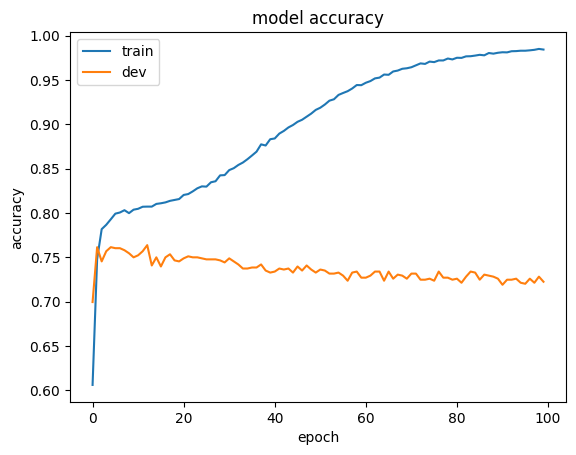

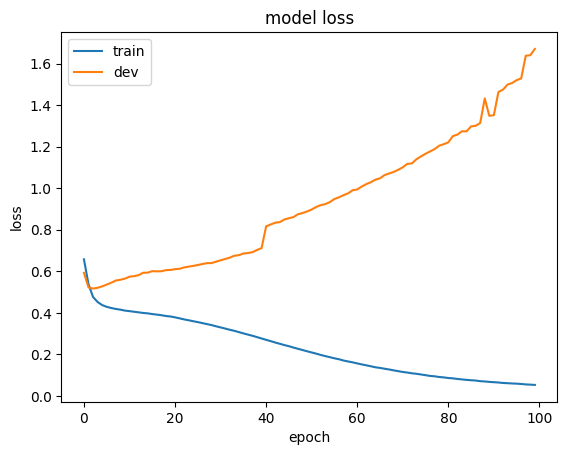

In [39]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['dev_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['dev_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### Exercise 2
Plots show that model ends up overfitting the training data. One way to prevent overfitting is to stop training once accuracy in the validation set starts decreasing.
- Could you retrain the model from scratch for only four epochs?

- Optionally, in PyTorch it is possible to implement custom early stopping mechanisms. The modified train_loop function below includes early stopping functionality:

```
# Early stopping is implemented in the train_loop function with patience parameter
history = train_loop(model, optimizer, epochs, patience=1, monitor="dev_acc")
```

Note: In PyTorch, we need to manually implement early stopping logic, unlike other frameworks such as Keras where it's provided as a built-in callback.

In [40]:
def train_loop(model, optimizer, epochs, patience=None, monitor="dev_acc"):

    # train mode for model
    model.train()

    history = {"loss": [], "dev_loss": [], "acc": [], "dev_acc": []}
    t0 = time.time()
    t_prev = t0

    # early stopping state
    best_metric = None
    patience_left = patience

    # perform the loop
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            probs, loss = model(xb, yb)

            # backward pass
            loss.backward()

            # optimizer step
            optimizer.step()

            # compute metrics
            total_loss += loss.item() * xb.size(0)
            total += yb.size(0)
            with torch.no_grad():
                preds = (probs > 0.5).float()
                correct += (preds == yb).sum().item()

        loss = total_loss / total
        acc = correct / total

        # Evaluation
        dev_loss, dev_acc = evaluate(model, dev_loader)

        # Store info
        history["loss"].append(loss)
        history["dev_loss"].append(dev_loss)
        history["acc"].append(acc)
        history["dev_acc"].append(dev_acc)

        # Logging
        t = time.time()
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train loss: {loss:.4f} - "
            f"Train acc: {acc:.4f} - "
            f"Dev loss: {dev_loss:.4f} - "
            f"Dev acc: {dev_acc:.4f} - "
            f"Time: {(t - t_prev)*1000:.2f}ms"
        )

        # Early stopping update
        if patience:
            current = history[monitor][-1]
            if best_metric is None:
                best_metric = current
            improved = (current >= best_metric) if monitor == "dev_acc" else (current <= best_metric)
            if improved:
                best_metric = current
                patience_left = patience
            else:
                patience_left -= 1
            if patience_left <= 0:
                print("Early stopping triggered")
                break

        # Updates
        t_prev = t

    print(f"Total training time: {t-t0}")
    return history

In [41]:
########################################
# backup
########################################
history_without_early_stop = history

########################################
# hyperparameters
########################################
learning_rate = 0.00100
epochs = 100
batch_size = 32
hidden_dim = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model
model = MLPClassifier(x_train.shape[1], hidden_dim, 1).to(device) # just one class, which can be 0 or 1

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs, patience=1, monitor="dev_acc")

Epoch 1/100 - Train loss: 0.6560 - Train acc: 0.6263 - Dev loss: 0.5879 - Dev acc: 0.7213 - Time: 508.95ms
Epoch 2/100 - Train loss: 0.5354 - Train acc: 0.7561 - Dev loss: 0.5220 - Dev acc: 0.7569 - Time: 485.91ms
Epoch 3/100 - Train loss: 0.4754 - Train acc: 0.7777 - Dev loss: 0.5150 - Dev acc: 0.7466 - Time: 689.25ms
Early stopping triggered
Total training time: 1.68410325050354


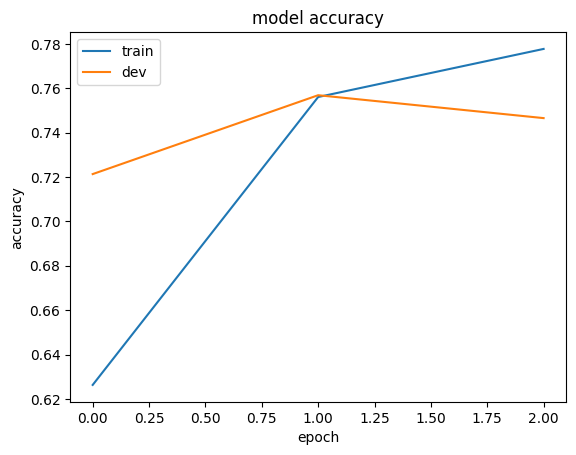

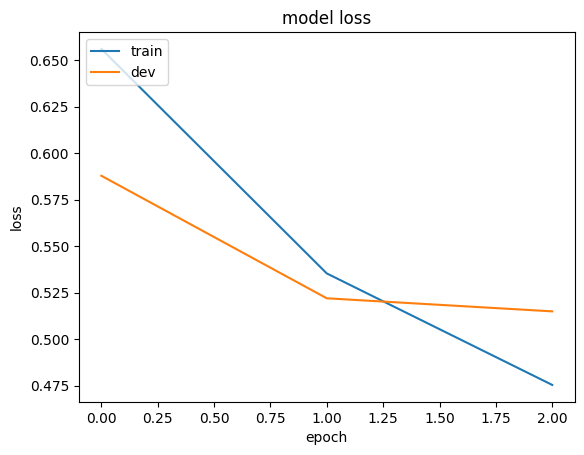

In [42]:
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['dev_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['dev_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

---
- Optionally you can try different activations (e.g ```Tanh```, ```Sigmoid```) instead of ```ReLU```.
- Or try different loss functions like ```MSELoss``` (mean squared error).

---

## 3.1 Adding new layers
In this section we will extend the model by adding new fully connected layers. By adding new layers we are increasing the capacity of the model but we are not reducing the overfitting, but for the moment we do not care about this.

### Exercise 3
- The code below defines a model with two hidden layers, add a third intermediate layer with 16 hidden units and ```ReLU``` activation.

In [43]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss() # just to make the criterion switch easier

    def forward(self, input, target=None):
        probs = self.layers(input)
        if target is not None: # compute loss if desired targets are given
          loss = self.criterion(probs, target)
        else:
          loss = None
        return probs, loss

In [44]:
########################################
# backup
########################################
history_with_early_stop = history

########################################
# hyperparameters
########################################
learning_rate = 0.00100
epochs = 20
batch_size = 32
hidden_dim = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model
model = MLPClassifier(x_train.shape[1], hidden_dim, 1).to(device) # just one class, which can be 0 or 1

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6405 - Train acc: 0.6163 - Dev loss: 0.5261 - Dev acc: 0.7523 - Time: 1118.62ms
Epoch 2/20 - Train loss: 0.4901 - Train acc: 0.7678 - Dev loss: 0.5256 - Dev acc: 0.7592 - Time: 1337.91ms
Epoch 3/20 - Train loss: 0.4493 - Train acc: 0.7913 - Dev loss: 0.5406 - Dev acc: 0.7534 - Time: 1216.43ms
Epoch 4/20 - Train loss: 0.4317 - Train acc: 0.8013 - Dev loss: 0.5366 - Dev acc: 0.7523 - Time: 1030.71ms
Epoch 5/20 - Train loss: 0.4134 - Train acc: 0.8142 - Dev loss: 0.5538 - Dev acc: 0.7466 - Time: 870.68ms
Epoch 6/20 - Train loss: 0.3928 - Train acc: 0.8256 - Dev loss: 0.5726 - Dev acc: 0.7477 - Time: 864.12ms
Epoch 7/20 - Train loss: 0.3707 - Train acc: 0.8380 - Dev loss: 0.5772 - Dev acc: 0.7408 - Time: 1065.87ms
Epoch 8/20 - Train loss: 0.3377 - Train acc: 0.8545 - Dev loss: 0.6229 - Dev acc: 0.7443 - Time: 929.74ms
Epoch 9/20 - Train loss: 0.3091 - Train acc: 0.8754 - Dev loss: 0.6444 - Dev acc: 0.7351 - Time: 814.53ms
Epoch 10/20 - Train loss: 0.2737 - Train 

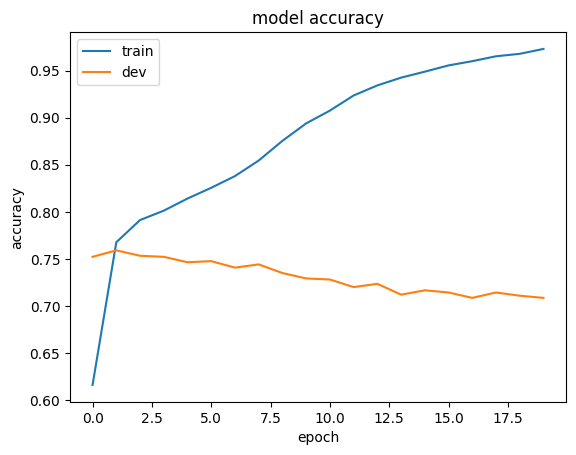

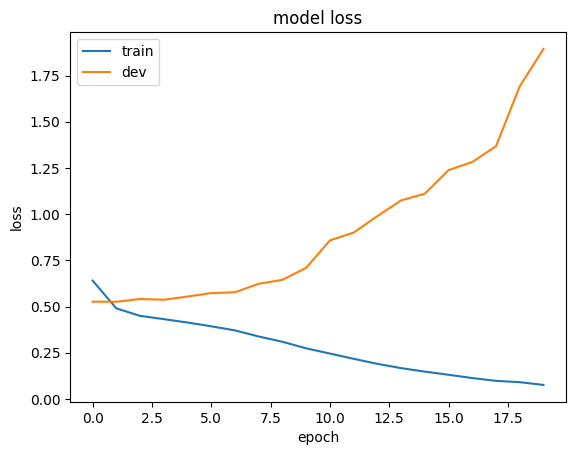

In [45]:
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['dev_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['dev_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## 4. Regularization techniques

We will apply the following ones:
- Reducing the network size
- Adding weight regularization
- Adding dropout

### 4.1 Reducing the network size
One way to prevent overfitting is to reduce the size of the model. As we know the size of the model is measured with the number of parameters that we need to learn. Remenber that the number of parameters are determined by the number of layers and the number of units per layer.



### Exercise 4
Run the following cell of code and try to answer the following question:
- Can you describe the relation of training and validation loss curves when traning with less parameters?

__Answer__: We reduce overfitting by reducing model size. Smaller models have less capacity to learn.

In [46]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss() # just to make the criterion switch easier

    def forward(self, input, target=None):
        probs = self.layers(input)
        if target is not None: # compute loss if desired targets are given
          loss = self.criterion(probs, target)
        else:
          loss = None
        return probs, loss

In [47]:
########################################
# backup
########################################
history_hidden_dim_16 = history

########################################
# hyperparameters
########################################
learning_rate = 0.00100
epochs = 20
batch_size = 32
hidden_dim = 4

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model
model = MLPClassifier(x_train.shape[1], hidden_dim, 1).to(device) # just one class, which can be 0 or 1

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6862 - Train acc: 0.5408 - Dev loss: 0.6551 - Dev acc: 0.6686 - Time: 440.18ms
Epoch 2/20 - Train loss: 0.5938 - Train acc: 0.7256 - Dev loss: 0.5444 - Dev acc: 0.7580 - Time: 450.41ms
Epoch 3/20 - Train loss: 0.4978 - Train acc: 0.7769 - Dev loss: 0.5132 - Dev acc: 0.7672 - Time: 444.73ms
Epoch 4/20 - Train loss: 0.4586 - Train acc: 0.7905 - Dev loss: 0.5159 - Dev acc: 0.7638 - Time: 445.45ms
Epoch 5/20 - Train loss: 0.4408 - Train acc: 0.7948 - Dev loss: 0.5264 - Dev acc: 0.7638 - Time: 433.77ms
Epoch 6/20 - Train loss: 0.4308 - Train acc: 0.8001 - Dev loss: 0.5328 - Dev acc: 0.7626 - Time: 441.21ms
Epoch 7/20 - Train loss: 0.4251 - Train acc: 0.8020 - Dev loss: 0.5446 - Dev acc: 0.7615 - Time: 447.23ms
Epoch 8/20 - Train loss: 0.4197 - Train acc: 0.8059 - Dev loss: 0.5524 - Dev acc: 0.7580 - Time: 442.84ms
Epoch 9/20 - Train loss: 0.4180 - Train acc: 0.8053 - Dev loss: 0.5666 - Dev acc: 0.7466 - Time: 449.43ms
Epoch 10/20 - Train loss: 0.4156 - Train acc: 

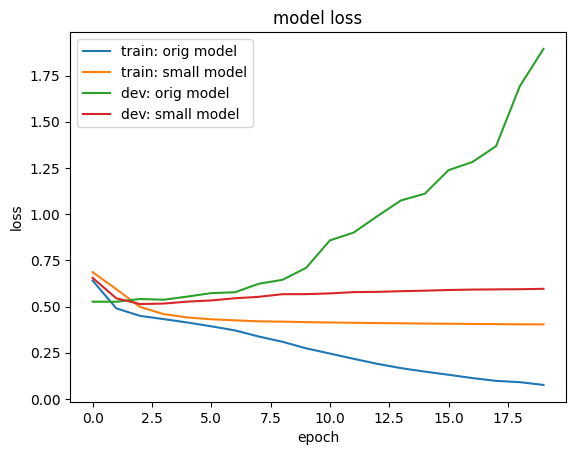

In [48]:
# summarize history for accuracy
plt.plot(history_hidden_dim_16['loss'])
plt.plot(history['loss'])

plt.plot(history_hidden_dim_16['dev_loss'])
plt.plot(history['dev_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: small model', 'dev: orig model', 'dev: small model'], loc='upper left')
plt.show()

We can compare the loss of bigger model with a higher _capacity_. Note that a model with a higher number of parameters has more memorization capacity and consequently can show a poorer generalization with higher risk of overfitting to training data.

### Exercise 5
Run the following cell of code and try to answer the following question:
- Can you describe the relation of training and validation loss curves when traning with more parameters?

__Answer__: The overfitting takes fewer steps than before, dev loss increases faster

In [49]:
########################################
# backup
########################################
history_hidden_dim_4 = history

########################################
# hyperparameters
########################################
learning_rate = 0.00100
epochs = 20
batch_size = 32
hidden_dim = 512

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model
model = MLPClassifier(x_train.shape[1], hidden_dim, 1).to(device) # just one class, which can be 0 or 1

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.5783 - Train acc: 0.6858 - Dev loss: 0.5086 - Dev acc: 0.7569 - Time: 593.26ms
Epoch 2/20 - Train loss: 0.4050 - Train acc: 0.8129 - Dev loss: 0.5511 - Dev acc: 0.7466 - Time: 570.03ms
Epoch 3/20 - Train loss: 0.2264 - Train acc: 0.9038 - Dev loss: 0.7178 - Dev acc: 0.7374 - Time: 657.27ms
Epoch 4/20 - Train loss: 0.0775 - Train acc: 0.9708 - Dev loss: 1.2325 - Dev acc: 0.7099 - Time: 510.90ms
Epoch 5/20 - Train loss: 0.0361 - Train acc: 0.9853 - Dev loss: 1.4883 - Dev acc: 0.7202 - Time: 511.27ms
Epoch 6/20 - Train loss: 0.0210 - Train acc: 0.9909 - Dev loss: 1.8918 - Dev acc: 0.7190 - Time: 515.33ms
Epoch 7/20 - Train loss: 0.0176 - Train acc: 0.9909 - Dev loss: 2.1866 - Dev acc: 0.7236 - Time: 521.36ms
Epoch 8/20 - Train loss: 0.0160 - Train acc: 0.9912 - Dev loss: 2.4440 - Dev acc: 0.7317 - Time: 519.26ms
Epoch 9/20 - Train loss: 0.0152 - Train acc: 0.9918 - Dev loss: 2.3713 - Dev acc: 0.7259 - Time: 523.96ms
Epoch 10/20 - Train loss: 0.0154 - Train acc: 

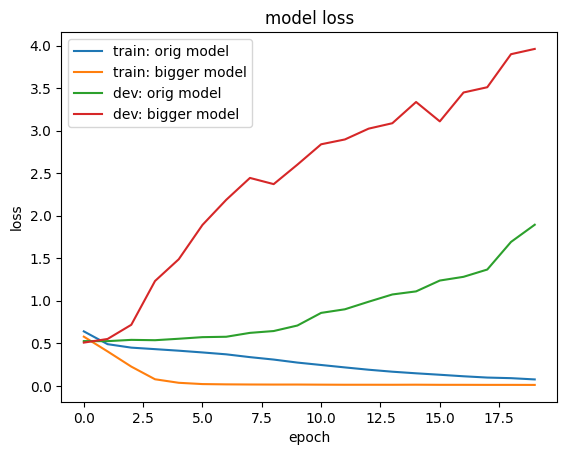

In [50]:
# summarize history for accuracy
plt.plot(history_hidden_dim_16['loss'])
plt.plot(history['loss'])

plt.plot(history_hidden_dim_16['dev_loss'])
plt.plot(history['dev_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: bigger model', 'dev: orig model', 'dev: bigger model'], loc='upper left')
plt.show()

-----

### 4.2 Adding weight regularization

Another common way to try avoiding overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called _weight regularization_, and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

- __L1 regularization__, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

- __L2 regularization__, where the cost added is proportional to the square of the value of the weights coefficients.

In PyTorch, weight regularization is typically implemented manually in the forward pass by adding the regularization term to the loss function. In this case, we'll use the L2 norm to regularize the weights of the model.

In [51]:
class MLPClassifierWithL2Regularization(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, l2_reg=0.0):
        super().__init__()
        # Two hidden layers with ReLU, matching the Keras example (16 units each)
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid(),
        )
        self.criterion = nn.BCELoss()
        self.l2_reg = l2_reg

    def forward(self, input, target=None):
        probs = self.layers(input)
        if target is not None: # compute loss if desired targets are given
            bce_loss = self.criterion(probs, target)
            # Add L2 regularization
            l2_loss = 0.0
            for param in self.parameters():
                l2_loss = l2_loss + torch.sum(param.pow(2))
            loss = bce_loss + self.l2_reg * l2_loss
        else:
            loss = None
        return probs, loss

In [52]:
########################################
# backup
########################################
history_hidden_dim_512 = history

########################################
# hyperparameters
########################################
learning_rate = 0.00100
epochs = 20
batch_size = 32
hidden_dim = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model
model = MLPClassifierWithL2Regularization(x_train.shape[1], hidden_dim, 1, 0.001).to(device) # just one class, which can be 0 or 1

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6720 - Train acc: 0.5941 - Dev loss: 0.5970 - Dev acc: 0.7271 - Time: 618.62ms
Epoch 2/20 - Train loss: 0.5518 - Train acc: 0.7500 - Dev loss: 0.5535 - Dev acc: 0.7580 - Time: 694.48ms
Epoch 3/20 - Train loss: 0.5078 - Train acc: 0.7793 - Dev loss: 0.5613 - Dev acc: 0.7557 - Time: 777.39ms
Epoch 4/20 - Train loss: 0.4964 - Train acc: 0.7842 - Dev loss: 0.5706 - Dev acc: 0.7546 - Time: 795.70ms
Epoch 5/20 - Train loss: 0.4890 - Train acc: 0.7900 - Dev loss: 0.5784 - Dev acc: 0.7431 - Time: 813.77ms
Epoch 6/20 - Train loss: 0.4853 - Train acc: 0.7916 - Dev loss: 0.5845 - Dev acc: 0.7431 - Time: 749.55ms
Epoch 7/20 - Train loss: 0.4802 - Train acc: 0.7951 - Dev loss: 0.5871 - Dev acc: 0.7489 - Time: 621.85ms
Epoch 8/20 - Train loss: 0.4794 - Train acc: 0.7928 - Dev loss: 0.5914 - Dev acc: 0.7511 - Time: 631.36ms
Epoch 9/20 - Train loss: 0.4752 - Train acc: 0.7968 - Dev loss: 0.5924 - Dev acc: 0.7523 - Time: 610.46ms
Epoch 10/20 - Train loss: 0.4715 - Train acc: 

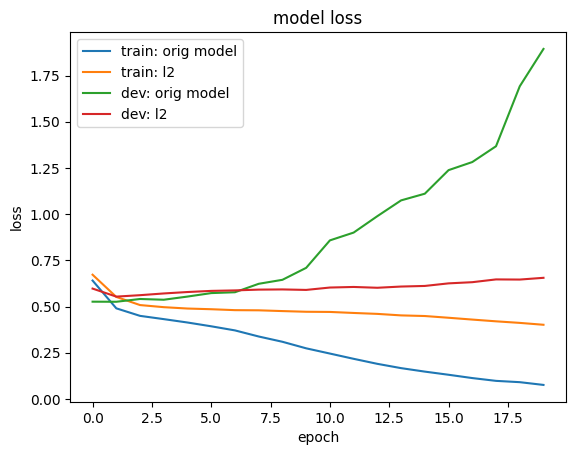

In [53]:
# summarize history for accuracy
plt.plot(history_hidden_dim_16['loss'])
plt.plot(history['loss'])

plt.plot(history_hidden_dim_16['dev_loss'])
plt.plot(history['dev_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: l2', 'dev: orig model', 'dev: l2'], loc='upper left')
plt.show()

### Exercise 6
- Explore different regularization weights (e.g. 0.001, 0.01, 0.1). Do you see any difference in the learning curves?
- You can try __L1 regularization__, or both together.

```
# L1 regularization implementation in PyTorch
def l1_loss(model):
    l1_loss = 0.0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
    return l1_loss

# L1 and L2 regularization at the same time
def l1_l2_loss(model, l1_reg=0.001, l2_reg=0.001):
    l1_loss_val = 0.0
    l2_loss_val = 0.0
    for param in model.parameters():
        l1_loss_val += torch.sum(torch.abs(param))
        l2_loss_val += torch.sum(param.pow(2))
    return l1_reg * l1_loss_val + l2_reg * l2_loss_val
```

-----

### 4.3 Adding dropout
Another popular regularization technique for deep learning is _dropout_. It has been proven to be very successful in many cases, which state-of-the-art of the architecture can be improved around 1-2% of accuracy.

The algorithm is simple: At every training step every unit has a probability $p$ of being dropped out (it will not take into account during the evaluation step, setting it to zero). In PyTorch, user needs to set a _dropout rate_, which is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In [54]:
class MLPClassifierWithL2RegularizationAndDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, l2_reg=0.0, dropout_p=0.0):
        super().__init__()
        # Two hidden layers with ReLU, matching the Keras example (16 units each)
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid(),
        )
        self.criterion = nn.BCELoss()
        self.l2_reg = l2_reg

    def forward(self, input, target=None):
        probs = self.layers(input)
        if target is not None: # compute loss if desired targets are given
            bce_loss = self.criterion(probs, target)
            # Add L2 regularization
            l2_loss = 0.0
            for param in self.parameters():
                l2_loss = l2_loss + torch.sum(param.pow(2))
            loss = bce_loss + self.l2_reg * l2_loss
        else:
            loss = None
        return probs, loss

In [55]:
########################################
# backup
########################################
history_l2 = history

########################################
# hyperparameters
########################################
learning_rate = 0.00100
epochs = 20
batch_size = 32
hidden_dim = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model
model = MLPClassifierWithL2RegularizationAndDropout(x_train.shape[1], hidden_dim, 1, dropout_p=0.5).to(device) # just one class, which can be 0 or 1

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6883 - Train acc: 0.5344 - Dev loss: 0.6674 - Dev acc: 0.6365 - Time: 659.54ms
Epoch 2/20 - Train loss: 0.6182 - Train acc: 0.6708 - Dev loss: 0.5451 - Dev acc: 0.7466 - Time: 799.98ms
Epoch 3/20 - Train loss: 0.5415 - Train acc: 0.7432 - Dev loss: 0.5123 - Dev acc: 0.7661 - Time: 831.53ms
Epoch 4/20 - Train loss: 0.5006 - Train acc: 0.7697 - Dev loss: 0.5046 - Dev acc: 0.7626 - Time: 812.25ms
Epoch 5/20 - Train loss: 0.4672 - Train acc: 0.7892 - Dev loss: 0.5063 - Dev acc: 0.7626 - Time: 861.05ms
Epoch 6/20 - Train loss: 0.4527 - Train acc: 0.7971 - Dev loss: 0.5220 - Dev acc: 0.7580 - Time: 646.99ms
Epoch 7/20 - Train loss: 0.4385 - Train acc: 0.8074 - Dev loss: 0.5171 - Dev acc: 0.7569 - Time: 663.95ms
Epoch 8/20 - Train loss: 0.4259 - Train acc: 0.8123 - Dev loss: 0.5353 - Dev acc: 0.7580 - Time: 670.33ms
Epoch 9/20 - Train loss: 0.4076 - Train acc: 0.8220 - Dev loss: 0.5492 - Dev acc: 0.7638 - Time: 632.62ms
Epoch 10/20 - Train loss: 0.3994 - Train acc: 

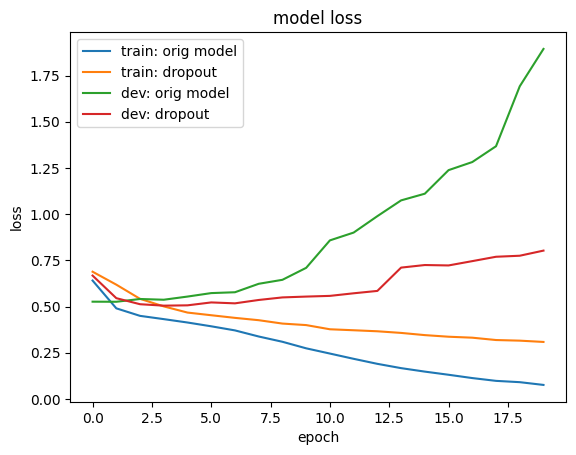

In [56]:
# summarize history for accuracy
plt.plot(history_hidden_dim_16['loss'])
plt.plot(history['loss'])

plt.plot(history_hidden_dim_16['dev_loss'])
plt.plot(history['dev_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: dropout', 'dev: orig model', 'dev: dropout'], loc='upper left')
plt.show()

### Exercise 7
- Try different dropout rates and decide which one is the best.

## Improve your model
It would be great if you could try improving the model by exploring different hyperparameters. For example,  you can explore the following ones:
- Learning Rates of the optimizer.
- Combination of different regularization techniques.
- Vocabulary size (using larger set of words).
- Number of hidden layers and size of the layers.
- Number of training epochs.


In [57]:
# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors, and tokenize the text
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label

# Create a tokenizer that takes the 10.000 most common words (10x more than before)
tokenizer = PyTorchTokenizer(num_words=10000)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts)  # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts)
x_dev = tokenizer.texts_to_matrix(dev_texts)
x_test = tokenizer.texts_to_matrix(test_texts)

# Converts the labels to a one-hot representation
y_train = torch.tensor(train_labels.values, dtype=torch.float32).unsqueeze(1)
y_dev = torch.tensor(dev_labels.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(test_labels.values, dtype=torch.float32).unsqueeze(1)

# Create datasets using PyTorch's TensorDataset
train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)
test_dataset = TensorDataset(x_test, y_test)

print('Text of the first examples: \n{}\n'.format(train_texts.iloc[0]))
print('Vector of the first example:\n{}\n'.format(x_train[0]))
print('Binary representation of the output:\n{}\n'.format(y_train[0]))
print('Shape of the training set    (nb_examples, vector_size): {}\n'.format(x_train.shape))
print('Shape of the training labels (nb_examples, vector_size): {}\n'.format(y_train.shape))

Text of the first examples: 
More good than great but Freeman and Judd make it work .

Vector of the first example:
tensor([0., 0., 1.,  ..., 0., 0., 0.])

Binary representation of the output:
tensor([1.])

Shape of the training set    (nb_examples, vector_size): torch.Size([6920, 10000])

Shape of the training labels (nb_examples, vector_size): torch.Size([6920, 1])



In [58]:
class MLPClassifierComplete(nn.Module):
    def __init__(self, input_dim, num_classes, l2_reg=0.0, dropout_p=0.0):
        super().__init__()
        # Two hidden layers with ReLU, matching the Keras example (16 units each)
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )
        self.criterion = nn.BCELoss()
        self.l2_reg = l2_reg

    def forward(self, input, target=None):
        probs = self.layers(input)
        if target is not None: # compute loss if desired targets are given
            bce_loss = self.criterion(probs, target)
            # Add L2 regularization
            l2_loss = 0.0
            for param in self.parameters():
                l2_loss = l2_loss + torch.sum(param.pow(2))
            loss = bce_loss + self.l2_reg * l2_loss
        else:
            loss = None
        return probs, loss

In [59]:
########################################
# hyperparameters
########################################
epochs = 50
batch_size = 32
lrs = [0.0001, 0.001, 0.01]
drs = [0.0, 0.2, 0.5]
regs = [0.0, 0.0001]
num_epochs = 100

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

history = {}
for lr in lrs:
    for reg in regs:
        for dr in drs:

          # model
          model = MLPClassifierComplete(x_train.shape[1], 1, l2_reg=reg, dropout_p=dr).to(device)

          # optimizer
          optimizer = torch.optim.Adam(model.parameters(), lr=lr)

          # execute the train loop
          history[f"lr{lr}-reg{reg}-dr{dr}"] = train_loop(model, optimizer, epochs, patience=1, monitor="dev_acc")

Epoch 1/50 - Train loss: 0.6614 - Train acc: 0.5951 - Dev loss: 0.5359 - Dev acc: 0.7729 - Time: 1385.35ms
Epoch 2/50 - Train loss: 0.3813 - Train acc: 0.8434 - Dev loss: 0.4892 - Dev acc: 0.7833 - Time: 1491.28ms
Epoch 3/50 - Train loss: 0.2045 - Train acc: 0.9237 - Dev loss: 0.5393 - Dev acc: 0.7890 - Time: 1472.93ms
Epoch 4/50 - Train loss: 0.1184 - Train acc: 0.9607 - Dev loss: 0.6466 - Dev acc: 0.7833 - Time: 1480.72ms
Early stopping triggered
Total training time: 5.830284833908081
Epoch 1/50 - Train loss: 0.6803 - Train acc: 0.5637 - Dev loss: 0.6106 - Dev acc: 0.7649 - Time: 1218.22ms
Epoch 2/50 - Train loss: 0.4368 - Train acc: 0.8194 - Dev loss: 0.4609 - Dev acc: 0.7959 - Time: 1233.45ms
Epoch 3/50 - Train loss: 0.2412 - Train acc: 0.9069 - Dev loss: 0.5212 - Dev acc: 0.7936 - Time: 1209.14ms
Early stopping triggered
Total training time: 3.6608102321624756
Epoch 1/50 - Train loss: 0.6918 - Train acc: 0.5253 - Dev loss: 0.6883 - Dev acc: 0.5092 - Time: 1224.10ms
Epoch 2/50 - Tr

In [60]:
best_epochs = []
accs = []
params_list = []
for params in history:
    params_list.append(params)
    index = np.argmax(history[params]['dev_acc'])
    best_epochs.append(index+1)
    accs.append(history[params]['dev_acc'][index])
pd.DataFrame(data={'params': params_list, 'best_epoch':best_epochs, 'acc':accs})

,params,best_epoch,acc
0,lr0.0001-reg0.0-dr0.0,3,0.788991
1,lr0.0001-reg0.0-dr0.2,2,0.795872
2,lr0.0001-reg0.0-dr0.5,4,0.800459
3,lr0.0001-reg0.0001-dr0.0,3,0.787844
4,lr0.0001-reg0.0001-dr0.2,3,0.799312
5,lr0.0001-reg0.0001-dr0.5,4,0.797018
6,lr0.001-reg0.0-dr0.0,1,0.793578
7,lr0.001-reg0.0-dr0.2,3,0.785550
8,lr0.001-reg0.0-dr0.5,2,0.799312
9,lr0.001-reg0.0001-dr0.0,2,0.786697
